# Generate new features to describe stores in year 2019

In [1]:
###############################################################################

from IPython.core.interactiveshell import InteractiveShell
import jupyternotify
import folium
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
from selenium import webdriver

InteractiveShell.ast_node_interactivity = "all"
get_ipython().register_magics(jupyternotify.JupyterNotifyMagics)
nest_asyncio.apply()

<IPython.core.display.Javascript object>

In [2]:
# df = pd.read_parquet('downsample.parquet')
%time df = pd.read_parquet('data.parquet')

%time df = df.dropna()
%time df = df[~df.Anomalous]
%time df = df[df.Date.dt.year==2019]

CPU times: user 59.9 s, sys: 47.1 s, total: 1min 47s
Wall time: 2min 3s
CPU times: user 24.1 s, sys: 25.1 s, total: 49.1 s
Wall time: 56.8 s
CPU times: user 6.18 s, sys: 12.9 s, total: 19.1 s
Wall time: 24 s
CPU times: user 2.25 s, sys: 3.11 s, total: 5.36 s
Wall time: 5.71 s


In [4]:
stores19 = pd.pivot_table(
    df,
    index='Store_num',
    values=[
        'Invoice',
        'Category','Vendor_num','Item_num',
        'Cents','Gallons','Bottle_count',
        'Longitude','Latitude'],
    aggfunc=['nunique','sum','mean'],
    fill_value=0,)

## Check for stores with multiple lat-long
# stores19['nunique'][['Latitude','Longitude']].max()

stores19 = stores19.drop(errors='ignore', columns=[
    ('nunique','Bottle_count'),
    ('nunique','Cents'),
    ('nunique','Gallons'),
    ('nunique','Latitude'),
    ('nunique','Longitude'),
    ('sum','Invoice'),
    ('sum','Latitude'),
    ('sum','Longitude')])

def pivot_cats(value):
    result = pd.pivot_table(
        df,
        index='Store_num',
        columns='Category',
        values=[value], # Input SINGLE column name b/c #1 below
        aggfunc='sum',
        fill_value=0,
        margins=True,
    )
    result = result.fillna(0)
    result = result.div(result.iloc[:,-1],axis=0) #1
    result.columns = result.columns.set_levels(
        [value+'_pc'],level=0)
    return result
stores19_cats = pd.concat(
    [pivot_cats(c) for c in ['Cents','Gallons']],
    axis=1)

stores19_cent_gal = pd.pivot_table(
    df,
    index='Store_num',
    columns='Category',
    values=['Cents','Gallons'],
    aggfunc='sum',
    fill_value=0,
    margins=True,
).fillna(0)
stores19_dol_per_gal = (
    stores19_cent_gal['Cents']/stores19_cent_gal['Gallons']/100)
stores19_dol_per_gal.columns = pd.MultiIndex.from_tuples(
    [('Dol_per_gal',c) for c in stores19_dol_per_gal.columns])

stores19_features = pd.concat(
    [stores19_cats,stores19,stores19_dol_per_gal],
    axis=1)
stores19_features.index.name = 'Store_num'
stores19_features = stores19_features[[
    ('Cents_pc','Vodka'),
    ('Cents_pc','Whiskey'),
    ('Cents_pc','Neutral'),
    ('nunique','Category'),
    ('nunique','Invoice'),
    ('nunique','Item_num'),
    ('nunique','Vendor_num'),
    ('sum','Cents'),
    ('mean','Latitude'),
    ('mean','Longitude'),
    ('Dol_per_gal','Tequila'),
    ('Dol_per_gal','All'),
]]

stores19_features = stores19_features.dropna()

pd.reset_option('max_rows')
pd.set_option('float_format', '{:.2f}'.format)
stores19_features.describe()

Cents_pc                  nunique                               \
Category    Vodka Whiskey Neutral Category  Invoice Item_num Vendor_num   
count     1578.00 1578.00 1578.00  1578.00  1578.00  1578.00    1578.00   
mean         0.26    0.33    0.00     8.07  1229.61   232.23      28.27   
std          0.07    0.09    0.00     1.01  1822.48   247.19      13.54   
min          0.01    0.04    0.00     4.00    19.00    16.00       9.00   
25%          0.21    0.28    0.00     7.00   228.00    79.00      20.00   
50%          0.26    0.34    0.00     8.00   599.00   123.00      24.00   
75%          0.30    0.39    0.00     9.00  1447.75   288.00      32.00   
max          0.58    0.76    0.07     9.00 20492.00  1536.00     112.00   

                   sum     mean           Dol_per_gal          
Category         Cents Latitude Longitude     Tequila     All  
count          1578.00  1578.00   1578.00     1578.00 1578.00  
mean       18759543.19    41.98    -93.05      109.29   58.21  
std        53066879.35     0.67      1.64       58.63   11.93  
min          113611.00    40.39    -96.56       37.82   30.94  
25%         2596270.75    41.56    -93.94       84.87   50.56  
50%         5569260.00    41.88    -93.07       97.51   56.28  
75%        16874246.50    42.49    -91.65      116.30   63.43  
max      1149131311.00    43.48    -90.18     1478.57  202.83

In [8]:
stores19_features.to_pickle('stores19.pickle')

# Why these features? Is there a spread?

In [6]:
InteractiveShell.ast_node_interactivity = "last"

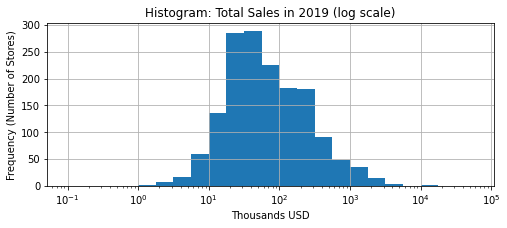

In [12]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()
sales = stores19_features[('sum','Cents')]/100/1_000
sales.hist(
    ax=ax, bins=[0]+[10**(i/4) for i in range(-4,20)],
    figsize=(8,3))
ax.set_xscale('log')
ax.set_xlabel('Thousands USD')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Total Sales in 2019 (log scale)');

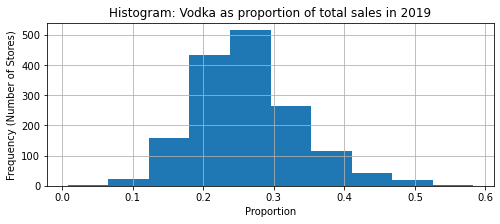

In [13]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

pc_vodka = stores19_features[('Cents_pc','Vodka')]
pc_vodka.hist(ax=ax, figsize=(8,3))

ax.set_xlabel('Proportion')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Vodka as proportion of total sales in 2019');

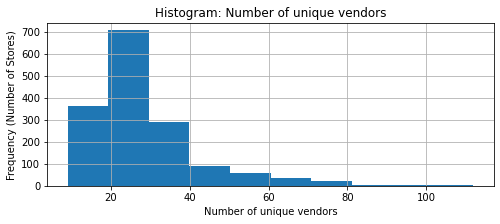

In [14]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

unique_vendors = stores19_features[('nunique','Vendor_num')]
unique_vendors.hist(ax=ax, figsize=(8,3))

ax.set_xlabel('Number of unique vendors')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Number of unique vendors');

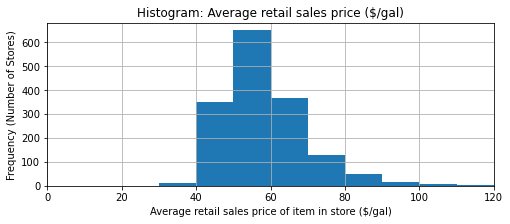

In [15]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

dol_per_gal = stores19_features[('Dol_per_gal','All')]
dol_per_gal.hist(ax=ax, figsize=(8,3), bins=[10*i for i in range(2,14)])

ax.set_xlim(0,120)

ax.set_xlabel('Average retail sales price of item in store ($/gal)')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Average retail sales price ($/gal)');
